In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [2]:
stocks = ["TATACONSUM.NS", "TATASTEEL.NS", "TCS.NS", "HAL.NS", "ICICIBANK.NS"]

# Download stock data
data = yf.download(stocks, start="2024-01-01", end="2025-01-01", interval="1d")
# Download stock data and keep only 'Close' column
close_data = yf.download(stocks, start="2024-01-01", end="2025-01-01", interval="1d")["Close"]
# Display the first few rows
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed

Price             Close                                                       \
Ticker           HAL.NS ICICIBANK.NS TATACONSUM.NS TATASTEEL.NS       TCS.NS   
Date                                                                           
2024-01-01  2777.945312   990.869812   1072.704346   137.087997  3739.366699   
2024-01-02  2743.986816   973.866150   1090.233521   136.842926  3711.991699   
2024-01-03  2820.847412   975.650818   1077.521118   132.676865  3622.262939   
2024-01-04  2854.510986   978.724365   1117.843140   131.598587  3597.782471   
2024-01-05  2947.490723   985.218445   1115.260864   131.010437  3667.544678   

Price              High                                                       \
Ticker           HAL.NS ICICIBANK.NS TATACONSUM.NS TATASTEEL.NS       TCS.NS   
Date                                                                           
2024-01-01  2810.920535   996.273246   1086.360197   138.166264  3759.873219   
2024-01-02  2790.132688   989.134730   

In [3]:
log_returns = np.log(data / data.shift(1)).dropna()
returns = log_returns['Close']

In [4]:
returns

Ticker,HAL.NS,ICICIBANK.NS,TATACONSUM.NS,TATASTEEL.NS,TCS.NS
Date,,,,,
2024-01-02,-0.012300,-0.017309,0.016209,-0.001789,-0.007348
2024-01-03,0.027625,0.001831,-0.011729,-0.030917,-0.024470
2024-01-04,0.011863,0.003145,0.036738,-0.008160,-0.006781
2024-01-05,0.032054,0.006613,-0.002313,-0.004479,0.019205
2024-01-08,-0.001084,-0.011844,-0.016159,-0.012423,-0.016073
...,...,...,...,...,...
2024-12-24,-0.002322,0.000347,0.005027,-0.009430,0.005085
2024-12-26,0.003079,0.000077,-0.007023,-0.000143,-0.002491
2024-12-27,0.000981,0.007831,0.007740,-0.010384,-0.001020


In [5]:
mu = returns.mean()

In [6]:
#

In [7]:
cov = returns.cov()

In [8]:
#cov

In [9]:
n = len(mu)

In [34]:
### MODEL 1: Mean-Variance Optimization ###
def mean_variance():
    model = gp.Model("Mean Variance")
    model.Params.OutputFlag = 0  # Suppress solver output

    # Define return range for efficient frontier
    target_returns = np.linspace(min(mu), max(mu), 30)

    results = []

    for target in target_returns:
        # Create model for each target return
        model.reset()
        w = model.addVars(n, lb=0, ub=1, name="w")  # Portfolio weights

        # Constraint: Sum of weights = 1
        model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1, "WeightConstraint")

        # Constraint: Expected return constraint
        model.addConstr(gp.quicksum(w[i] * mu[i] for i in range(n)) == target, "ReturnConstraint")

        # Objective: Minimize risk (variance)
        model.setObjective(
            gp.quicksum(w[i] * cov.iloc[i, j]* w[j]  for i in range(n) for j in range(n)), GRB.MINIMIZE
        )

        # Optimize model
        model.optimize()

        if model.status == GRB.OPTIMAL:
            risk = np.sqrt(model.objVal)  # Convert variance to standard deviation
            results.append((target, risk))

    # Store results in a DataFrame
    df = pd.DataFrame(results, columns=["Return", "Risk"])
    model.write('output/mv.lp')

    return df

In [13]:

def mean_semivariance():
    """
    Implements Mean-Semivariance Portfolio Optimization using Gurobi.
    
    Returns:
        DataFrame: Returns and downside risk values for the efficient frontier.
    """

    model = gp.Model("Mean-Semivariance")
    model.Params.OutputFlag = 0  # Suppress solver output

    # Define return range for efficient frontier
    target_returns = np.linspace(min(mu), max(mu), 30)
    T = 5

    results = []

    for target in target_returns:
        model.reset()
        w = model.addVars(n, lb=0, ub=1, name="w")  # Portfolio weights
        z = model.addVars(T, lb=0, name="z")  # Downside deviations

        # Constraint: Sum of weights = 1
        model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1, "WeightConstraint")

        # Constraint: Expected return constraint
        expected_return = gp.quicksum(w[i] * mu[i] for i in range(n))
        model.addConstr(expected_return == target, "ReturnConstraint")

        # Constraint: Compute downside deviations
        for t in range(T):
            realized_return = gp.quicksum(w[i] * returns[t, i] for i in range(n))
            model.addConstr(z[t] >= target - realized_return, "DownsideConstraint_{}".format(t))

        # Objective: Minimize semivariance (Mean Squared Downside Deviation)
        model.setObjective(gp.quicksum(z[t] * z[t] for t in range(T)) / T, GRB.MINIMIZE)

        # Optimize model
        model.optimize()

        if model.status == GRB.OPTIMAL:
            risk = np.sqrt(model.objVal)  # Convert semivariance to semideviation (downside risk)
            results.append((target, risk))

    # Store results in a DataFrame
    df = pd.DataFrame(results, columns=["Return", "Downside Risk"])
    model.write('output/mean_semivariance.lp')

    return df


In [35]:
### Model2: **Mean Absolute Deviation (MAD) Model Implementation** ###
def mean_absolute_deviation():
    model = gp.Model("Mean Absolute Deviation")
    model.Params.OutputFlag = 0

    # Define decision variables
    w = model.addVars(n, lb=0,ub=1, name="w")

    # Define auxiliary variables for absolute deviations
    z = model.addVars(T, name="z")

    # Expected portfolio return
    portfolio_return = gp.quicksum(w[j] * mu[j] for j in range(n))

    # Target return range for the efficient frontier
    target_returns = np.linspace(min(mu), max(mu), 30)  # 30 points for efficient frontier
    results = []

    for R in target_returns:
        model.reset()

        # Constraints
        model.addConstr(gp.quicksum(w[j] for j in range(n)) == 1, "WeightConstraint")
        model.addConstr(portfolio_return >= R, "ReturnConstraint")

        for t in range(T):
            realized_return = gp.quicksum(w[j] * log_returns.iloc[t, j] for j in range(n))
            model.addConstr(z[t] >= realized_return - portfolio_return)
            model.addConstr(z[t] >= - (realized_return - portfolio_return))

        # Objective: Minimize Mean Absolute Deviation (MAD)
        model.setObjective(gp.quicksum(z[t] for t in range(T)) / T, GRB.MINIMIZE)

        # Solve the model
        model.optimize()

        if model.status == GRB.OPTIMAL:
            risk = model.objVal  # MAD (Risk measure)
            results.append((R, risk))
        
    df =pd.DataFrame(results, columns=["Return", "Risk"])
    model.write('output/mad.lp')
    return df    

In [36]:
### **Model 3: Value-at-Risk (VaR) Optimization** ###
def value_at_risk(alpha = 0.95):#default 95%
    model = gp.Model("Value-at-Risk")
    model.Params.OutputFlag = 0  # Suppress solver output

    # Define risk aversion parameter (adjust as needed)
    theta_inv = 1.645  # Corresponds to alpha% confidence level

    # Target return range
    target_returns = np.linspace(min(mu), max(mu), 30)  # 30 return levels for frontier
    results = []

    for target in target_returns:
        model.reset()
        
        # Decision variables
        w = model.addVars(n, lb=0,ub=1, name="w")  # Portfolio weights
        A = model.addVar(lb=0, name="A")  # Auxiliary risk variable

        # Expected portfolio return
        portfolio_return = gp.quicksum(w[i] * mu[i] for i in range(n))

        # Risk constraint: A² ≥ w' Σ w
        risk_expr = gp.quicksum(w[i] * w[j] * cov.iloc[i, j] for i in range(n) for j in range(n))
        model.addConstr(A**2 >= risk_expr, "RiskConstraint")

        # Constraint: Target return
        model.addConstr(portfolio_return == target, "ReturnConstraint")

        # Constraint: Sum of weights = 1
        model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1, "WeightConstraint")

        # Objective: Minimize -Return + θ⁻¹ * A
        model.setObjective(-portfolio_return + theta_inv * A, GRB.MINIMIZE)

        # Solve model
        model.optimize()

        if model.status == GRB.OPTIMAL:
            risk = A.X  # Extract risk measure
            results.append((target, risk))

    df = pd.DataFrame(results, columns=["Return", "Risk"])
    model.write('output/var.lp')
    return df

In [37]:
### **Model 4: Conditional Value-at-Risk (CVaR) Optimization** ###
def conditional_value_at_risk():
    model = gp.Model("Conditional Value-at-Risk")
    model.Params.OutputFlag = 0  # Suppress solver output

    # Define confidence level
    alpha = 0.95  # 95% confidence level
    beta = 1 / ((1 - alpha) * T)  # Scaling factor for CVaR

    # Target return range
    target_returns = np.linspace(min(mu), max(mu), 30)  # 30 return levels for frontier
    results = []

    for target in target_returns:
        model.reset()

        # Decision variables
        w = model.addVars(n, lb=0, ub=1, name="w")  # Portfolio weights
        zeta = model.addVar(name="zeta")  # CVaR threshold variable
        y = model.addVars(T, lb=0, name="y")  # Auxiliary risk variables

        # Expected portfolio return
        portfolio_return = gp.quicksum(w[i] * mu[i] for i in range(n))

        # CVaR risk constraint
        for t in range(T):
            model.addConstr(y[t] >= -gp.quicksum(w[i] * log_returns.iloc[t, i] for i in range(n)) - zeta)

        # Constraint: Target return
        model.addConstr(portfolio_return == target, "ReturnConstraint")

        # Constraint: Sum of weights = 1
        model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1, "WeightConstraint")

        # Objective: Minimize CVaR
        model.setObjective(zeta + beta * gp.quicksum(y[t] for t in range(T)), GRB.MINIMIZE)

        # Solve model
        model.optimize()

        if model.status == GRB.OPTIMAL:
            risk = zeta.X + beta * sum(y[t].X for t in range(T))  # Compute CVaR
            results.append((target, risk))

    df = pd.DataFrame(results, columns=["Return", "Risk"])
    model.write('output/cvar.lp')
    return df

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3776\1796041959.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(gp.quicksum(w[i] * mu[i] for i in range(n)) == target, "ReturnConstraint")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3776\2933439884.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_return = gp.quicksum(w[j] * mu[j] for j in range(n))
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3776\4266887493.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavio

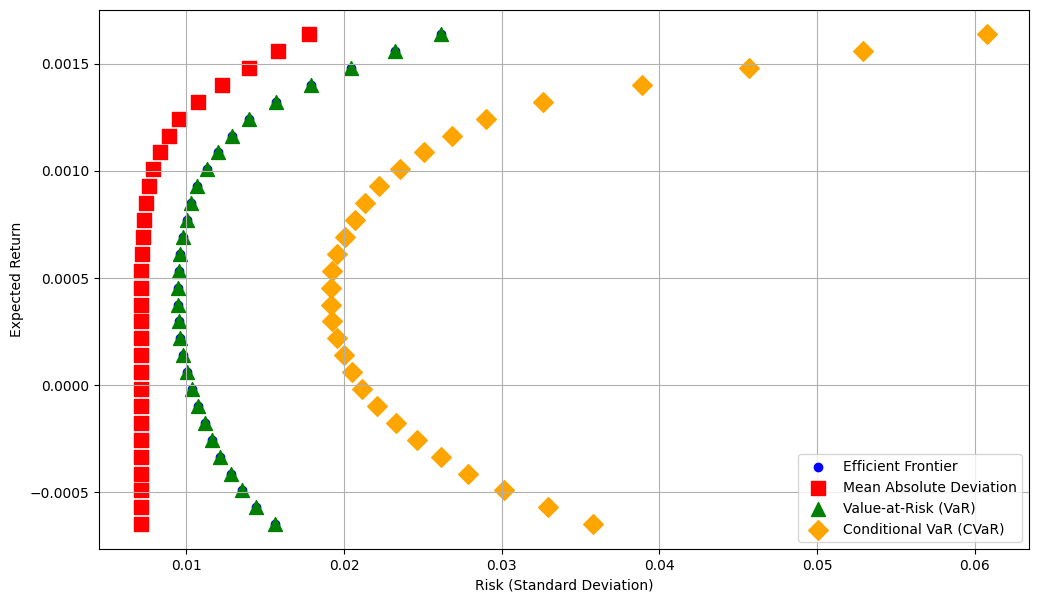

In [40]:

### **Run Models & Collect Data for Plotting** ###
df_efficient = mean_variance()
mad_return = mean_absolute_deviation()
var_return = value_at_risk()
cvar_return = conditional_value_at_risk()

# **Plot Efficient Frontier & Other Models**
plt.figure(figsize=(12, 7))

# Efficient Frontier
plt.scatter(df_efficient["Risk"], df_efficient["Return"], marker="o", linestyle="-", color="b", label="Efficient Frontier")

# Other Portfolio Models
plt.scatter(mad_return["Risk"], mad_return["Return"], color="r", marker="s", s=100, label="Mean Absolute Deviation")
plt.scatter(var_return["Risk"], var_return["Return"], color="g", marker="^", s=100, label="Value-at-Risk (VaR)")
plt.scatter(cvar_return["Risk"], cvar_return["Return"], color="orange", marker="D", s=100, label="Conditional VaR (CVaR)")

# Labels and Legend
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Expected Return")
#plt.title("Efficient Frontier & Alternative Portfolio Models")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3776\1796041959.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstr(gp.quicksum(w[i] * mu[i] for i in range(n)) == target, "ReturnConstraint")


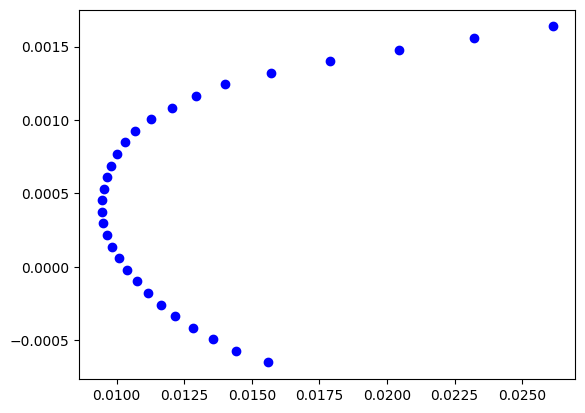

In [41]:
df_efficient = mean_variance()
# Efficient Frontier
plt.scatter(df_efficient["Risk"], df_efficient["Return"], marker="o", linestyle="-", color="b", label="Efficient Frontier")


In [14]:
df_meansemivar = mean_semivariance()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12368\869801918.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_return = gp.quicksum(w[i] * mu[i] for i in range(n))


KeyError: (0, 0)